# Human Activity Recognition using 2D CNN

In [7]:
import tensorflow as tf
import seaborn as sns
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scipy.stats as stats
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Data Cleaning & Preprocessing

In [8]:
#open data.txt
file = open('data.txt')
lines = file.readlines()
#process lines and insert data to a list
processedList = []
for i, line in enumerate(lines):
    try:
        line = line.split(',')
        last = line[5].split(';')[0]
        last = last.strip()
        if last == '':
            break;
        temp = [line[0], line[1], line[2], line[3], line[4], last]
        processedList.append(temp)
    except:
        print(f'An error happend in processing data line : {i}')

An error happend in processing data line : 281873
An error happend in processing data line : 281874
An error happend in processing data line : 281875


In [9]:
#create a DataFrame with the processed data and proper column names 
columns = ['User', 'Activity', 'Time', 'x', 'y', 'z']
data = pd.DataFrame(data = processedList, columns = columns)
data.head()

,User,Activity,Time,x,y,z
0,33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.1849703,12.108489,7.205164


In [10]:
#convert x,y,z to floar data type (Its string)
data['x'] = data['x'].astype('float')
data['y'] = data['y'].astype('float')
data['z'] = data['z'].astype('float')

In [11]:
#make list of activities 
activities = data['Activity'].value_counts().index
activities

Index(['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing'], dtype='object')

In [12]:
#drop User and Time columns
df = data.drop(['User', 'Time'], axis = 1).copy()
df.head()

,Activity,x,y,z
0,Jogging,-0.694638,12.680544,0.503953
1,Jogging,5.012288,11.264028,0.953424
2,Jogging,4.903325,10.882658,-0.081722
3,Jogging,-0.612916,18.496431,3.023717
4,Jogging,-1.184970,12.108489,7.205164


# Analyzing class label distribution

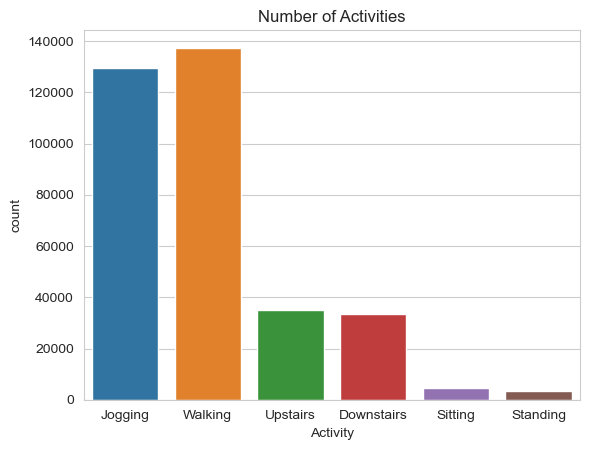

In [13]:
sns.set_style('whitegrid')
sns.countplot(x = 'Activity', data = df)
plt.title('Number of Activities')
plt.show()

In [16]:
data['Activity'].value_counts()

Walking       137375
Jogging       129392
Upstairs       35137
Downstairs     33358
Sitting         4599
Standing        3555
Name: Activity, dtype: int64

The data is unbalanced. We need to balance data.If we use this unbalance data our model will overfit

In [17]:
#take only the first 3555 lines for each activity
#create seprate data frames for each activity
Walking = df[df['Activity']=='Walking'].head(3555).copy()
Jogging = df[df['Activity']=='Jogging'].head(3555).copy()
Upstairs = df[df['Activity']=='Upstairs'].head(3555).copy()
Downstairs = df[df['Activity']=='Downstairs'].head(3555).copy()
Sitting = df[df['Activity']=='Sitting'].head(3555).copy()
Standing = df[df['Activity']=='Standing'].copy()

#create balance data frame
balanced_data = pd.DataFrame()
balanced_data = balanced_data.append([Walking, Jogging, Upstairs, Downstairs, Sitting, Standing])
balanced_data.shape

C:\Users\Alireza\AppData\Local\Temp\ipykernel_20504\536176885.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_data = balanced_data.append([Walking, Jogging, Upstairs, Downstairs, Sitting, Standing])


(21330, 4)

In [18]:
#see the distribution of data
balanced_data['Activity'].value_counts()

Walking       3555
Jogging       3555
Upstairs      3555
Downstairs    3555
Sitting       3555
Standing      3555
Name: Activity, dtype: int64

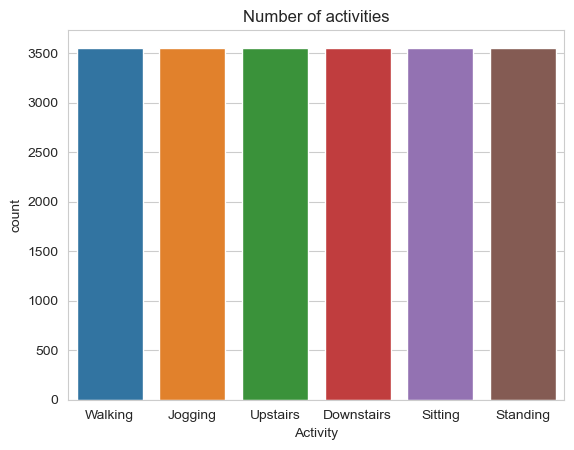

In [19]:
sns.set_style('whitegrid')
sns.countplot(x = 'Activity', data = balanced_data)
plt.title('Number of activities')
plt.show()

In [17]:
#convert string to numeric datatype by LabelEncoder from sklearn
label = LabelEncoder()
balanced_data['label'] = label.fit_transform(balanced_data['Activity'])
label.classes_

array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype=object)

In [18]:
#check out balance data
balanced_data.head()

,Activity,x,y,z,label
597,Walking,0.844462,8.008764,2.792171,5
598,Walking,1.116869,8.621680,3.786457,5
599,Walking,-0.503953,16.657684,1.307553,5
600,Walking,4.794363,10.760075,-1.184970,5
601,Walking,-0.040861,9.234595,-0.694638,5


# Standarizing Data

In [22]:
#we neeed to standarize our data (cause x,y,z dont have same variance)
Data = balanced_data[['x', 'y', 'z']]
labels = balanced_data['label']
Data.head()
labels.head()

597    5
598    5
599    5
600    5
601    5
Name: label, dtype: int32

In [24]:
#for standarizing data use StandardScaler() from sklearn/
scaler = StandardScaler()
Data = scaler.fit_transform(Data)
ScaledData = pd.DataFrame(data = Data, columns = ['x', 'y', 'z'])
ScaledData['label'] = labels.values
ScaledData.head()

,x,y,z,label
0,0.000503,-0.099190,0.337933,5
1,0.073590,0.020386,0.633446,5
2,-0.361275,1.588160,-0.103312,5
3,1.060258,0.437573,-0.844119,5
4,-0.237028,0.139962,-0.698386,5


# Preparing Data

In [29]:
#divide the data into frames of 4 seconds by scipy.stats
Fs = 20
FrameSize = Fs*4 #*0 seconds
#hop size is our overlapping
HopSize = Fs*2 #40 seconds

In [30]:
#creates frames of 4 seconds(80 observations)
#returns two np.arrays.rames containing all the 4 seconds frames and 
#labels containing its corresponding data 
def GetFrames(df, frame_size, hop_size):

    N_FEATURES = 3

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x = df['x'].values[i: i + frame_size]
        y = df['y'].values[i: i + frame_size]
        z = df['z'].values[i: i + frame_size]
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df['label'][i: i + frame_size])[0][0]
        frames.append([x, y, z])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

In [34]:
X,Y = GetFrames(ScaledData,FrameSize,HopSize)

X.shape, Y.shape

C:\Users\Alireza\AppData\Local\Temp\ipykernel_12164\1555157123.py:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df['label'][i: i + frame_size])[0][0]


((532, 80, 3), (532,))

In [36]:
#we had 3555 observation for each activities.So we have total (3555*6)
#observations.This devide by the hop size which is 40.So we have 532 frames\
#in our data
(3555*6)/40

533.25

In [42]:
#we devide the data into training and test data 
#using train_test_split() from sklearn
#We are going to use 80% of the data for training model(Its collected from 
#readme text)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0, stratify = Y)

In [43]:
X_train.shape, X_test.shape

((425, 80, 3), (107, 80, 3))

In [51]:
X_train[0].shape, X_test[0].shape

((80, 3), (80, 3))

In [54]:
#we  want to use CNN model so we have to reshape our data
X_train = X_train.reshape(425, 80, 3, 1)
X_test = X_test.reshape(107, 80, 3, 1)
X_train[0].shape, X_test[0].shape

((80, 3, 1), (80, 3, 1))

# Model Training & Evaluation

A 2-D convolutional layer applies sliding convolutional filters to 2-D input. The layer convolves the input by moving the filters along the input vertically and horizontally, computing the dot product of the weights and the input, and then adding a bias term.

In [78]:
#create model 
#add sequence layer
model = Sequential()
#add first layer 16(filters for first layer,(2,2)kernel size
#for the first layer we need to pass input
model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = X_train[0].shape))
#ten percent of neurons
model.add(Dropout(0.1))

#second layer(we dont need pass input in hidden layer)
model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

#last layer(We have 6 classes)
model.add(Dense(6, activation='softmax'))

In [79]:
#complile our model
#our model will build based on accuracy
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(X_train, y_train, epochs = 10, validation_data= (X_test, y_test), verbose=1)

Epoch 1/10
14/14 [==============================] - 1s 15ms/step - loss: 1.6744 - accuracy: 0.2682 - val_loss: 1.4167 - val_accuracy: 0.4486
Epoch 2/10
14/14 [==============================] - 0s 7ms/step - loss: 1.3782 - accuracy: 0.4094 - val_loss: 1.1171 - val_accuracy: 0.7664
Epoch 3/10
14/14 [==============================] - 0s 7ms/step - loss: 1.0572 - accuracy: 0.6306 - val_loss: 0.7854 - val_accuracy: 0.8224
Epoch 4/10
14/14 [==============================] - 0s 7ms/step - loss: 0.7999 - accuracy: 0.7459 - val_loss: 0.5712 - val_accuracy: 0.8318
Epoch 5/10
14/14 [==============================] - 0s 7ms/step - loss: 0.6588 - accuracy: 0.7859 - val_loss: 0.4508 - val_accuracy: 0.8411
Epoch 6/10
14/14 [==============================] - 0s 7ms/step - loss: 0.4725 - accuracy: 0.8376 - val_loss: 0.3352 - val_accuracy: 0.8879
Epoch 7/10
14/14 [==============================] - 0s 7ms/step - loss: 0.3957 - accuracy: 0.8753 - val_loss: 0.3485 - val_accuracy: 0.8692
Epoch 8/10
14/14 [=

# Plot training & validation accuracy values

In [80]:
def PlotLearningCurve(history, epochs):
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

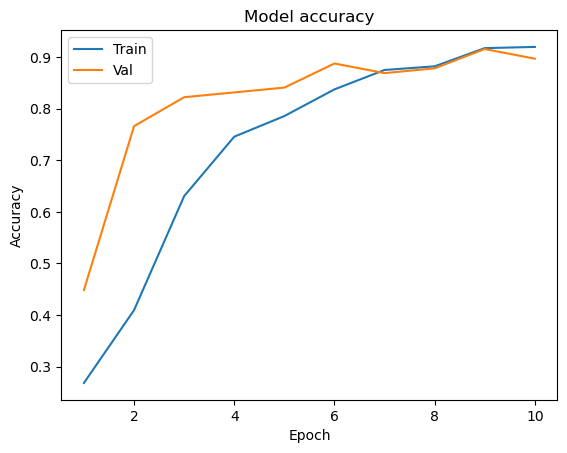

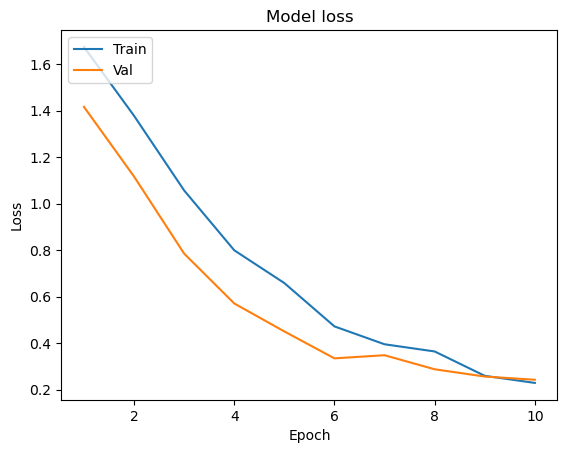

In [81]:
plot_learningCurve(history, 10)